<a href="https://colab.research.google.com/github/BetriuJaume/TFG-code/blob/main/Data_exp_and_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for Data exploration and Random Forest models:

In [1]:
!pip install pyreadstat
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177.0 MB 54 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.3-py2.py3-none-any.whl size=177103819 sha256=b01fb3705a89ed561268d0cee24e4216b65fb1217c47816a4d243e47d97e40dc
  Stored in directory: /root/.cache/pip/wheels/64/86/0f/d54be71f64b85d238edb037069bc866f2156cc563bf02be527
Successfully built h2o


In [2]:
import pyreadstat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import h2o

from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import chi2_contingency
from h2o.estimators import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3t6ox965
  JVM stdout: /tmp/tmp3t6ox965/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp3t6ox965/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,"14 days, 21 hours and 52 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_yos2jd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [4]:
%matplotlib inline

In [6]:
dades_orig=pd.read_spss('EarlyLifeCovidPACIENTES V6 ID.sav')
dades_extra=pd.read_spss('extra_data.sav')

dades_extra['Talla_mt'] = dades_extra['Talla']/100
dades_extra=dades_extra.rename(columns = {'Tabaco_Sino':'Tabaco_SIno'})
dades_extra=dades_extra.drop(list(set(dades_extra.columns)-set(dades_orig)),axis=1)
dades_extra['IUGR_missing']= [1.]*len(dades_extra)

for colu in dades_extra.columns[12:-2]:
    dades_extra[colu]=['si' if x==1 else 'no' for x in dades_extra[colu]]

dades=pd.concat([dades_orig, dades_extra], ignore_index=True)

def canvi_tab(elem):
  if((elem=='si (pasado o actual)')):
    return 'yes'
  if(elem=='nunca'):
    return 'no'
def canvi(elem):
  if(elem=='si'):
    return 'yes'
  if(elem=='no'):
    return 'no'
def canvi_UCI(elem):
  if(elem==1):
    return 'Yes'
  if(elem==0):
    return 'No'
def canvi_sex(elem):
  if(elem=='mujer'):
    return 'woman'
  if(elem=='hombre'):
    return 'man'

dades['Tabaco_SIno']=dades['Tabaco_SIno'].apply(canvi_tab)
dades['UCI']=dades['UCI'].apply(canvi_UCI)
for columna in dades.columns[14:]:
  dades[columna]=dades[columna].apply(canvi)
dades['Gender']=dades['Gender'].apply(canvi_sex)
dades['IUGR_calc']=dades['IUGR_calc'].apply(canvi_UCI)
dades.columns=pd.Index(['ID', 'UCI', 'IUGR_missing', 'Age', 'Gender', 'Size', 'Weight',
       'Size_mt', 'IMC', 'BW', 'BW_2500', 'percentil_birth', 'IUGR_calc',
       'Tobacco_yes_no', 'Hipertension', 'Heart_diseases', 'DM', 'Dyslipidemia',
       'Obesity', 'Kidney_disease', 'Autoimmune', 'Cancer', 'Thyroid', 'Infectious',
       'Psychiatric'])

dades['Age']=dades['Age'].fillna(dades['Age'].mean())
dades['Size']=dades['Size'].fillna(dades['Size'].mean())
dades['Weight']=dades['Weight'].fillna(dades['Weight'].mean())
dades['Size_mt']=dades['Size']/100
dades['IMC']=dades['IMC'].fillna(dades['IMC'].mean())
dades['percentil_birth']=dades['percentil_birth'].fillna(dades['percentil_birth'].mean())
dades['IUGR_calc']=dades['IUGR_calc'].fillna(dades['IUGR_calc'].mode().iloc[0])

In [7]:
dades_train = dades.sample(frac=0.8, random_state=25).drop('ID',axis=1)
dades_test = dades.drop(dades_train.index).drop('ID',axis=1)

# Data Exploration

Visualization of the UCI categories:

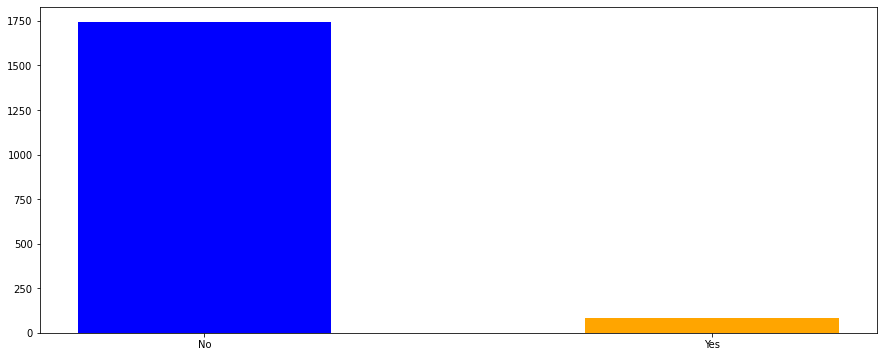

In [8]:
fig, ax=plt.subplots(figsize=(15,6))
plt.bar(['No','Yes'],[len(dades_train[dades_train['UCI']=='No']),len(dades_train[dades_train['UCI']=='Yes'])],width=0.5,color=['blue','orange'],linewidth=4)

fig.show()

Histogram for Age and Weight:

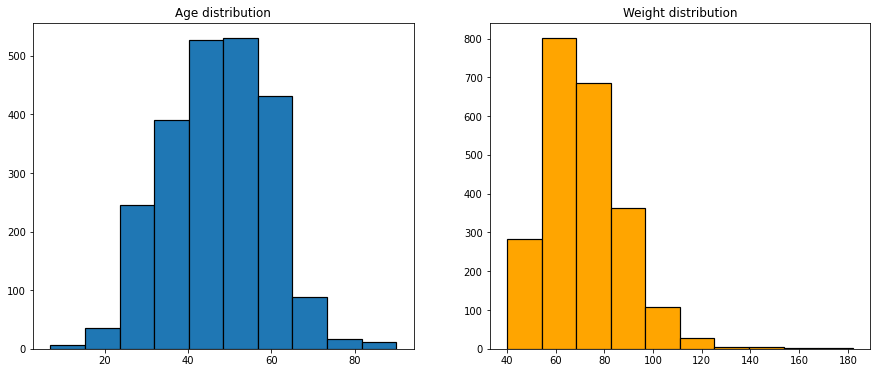

In [9]:
fig, ax=plt.subplots(1,2,figsize=(15,6))

ax[0].hist(dades['Age'],edgecolor='black',linewidth=1.2)
ax[0].set_title('Age distribution')
ax[1].hist(dades['Weight'],color='orange',edgecolor='black',linewidth=1.2)
ax[1].set_title('Weight distribution')

fig.show()

Boxplot for Gender-Weight and Gender-IMC:

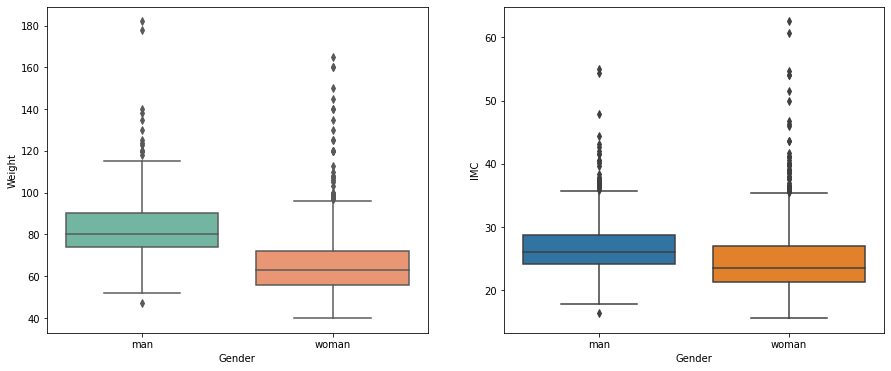

In [10]:
fig, ax=plt.subplots(1,2,figsize=(15,6))

sns.boxplot(x='Gender',y='Weight',data=dades,palette=sns.color_palette('Set2'), ax=ax[0])

sns.boxplot(x='Gender',y='IMC',data=dades,palette=sns.color_palette(), ax=ax[1])

Boxplot BW_2500-Weight-IUGR:

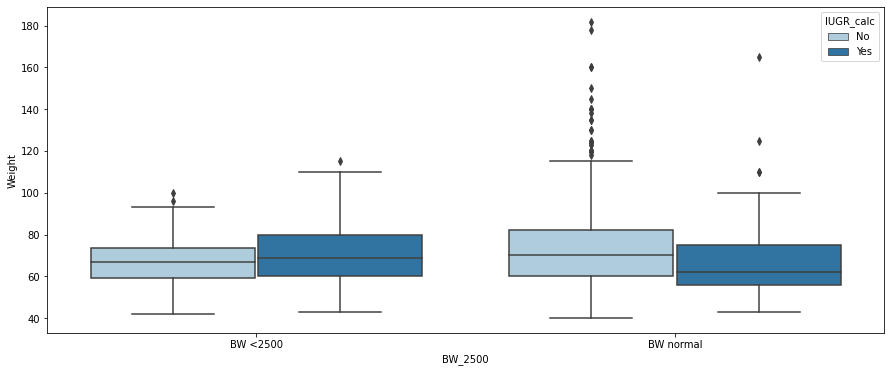

In [11]:
fig, ax=plt.subplots(figsize=(15,6))
sns.boxplot(y='Weight',x='BW_2500',data=dades,hue='IUGR_calc',palette=sns.color_palette("Paired"))

fig.show()

In [12]:
print(len(dades.loc[(dades['BW_2500'] == 'BW <2500') & (dades['IUGR_calc'] == 'Yes')]))
print(len(dades.loc[(dades['BW_2500'] == 'BW <2500') & (dades['IUGR_calc'] == 'No')]))

136
47


Categorical variables and UCI:

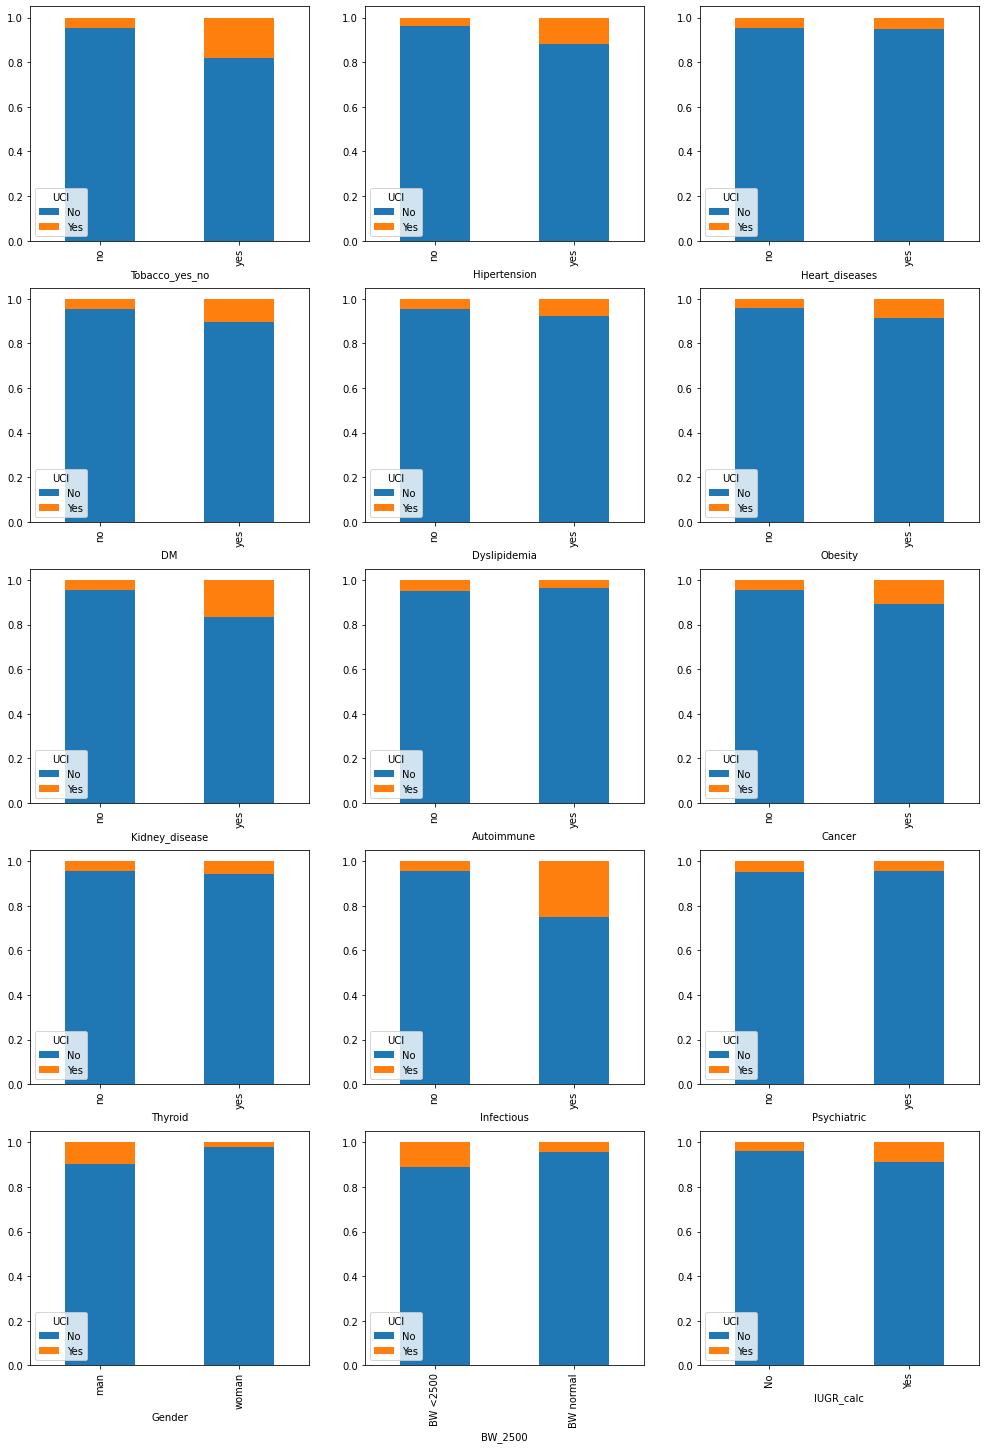

In [13]:
llista_dades=[]
column_names=list(dades.columns[13:])+['Gender','BW_2500','IUGR_calc']
for columna in column_names:
  llista_dades.append(pd.crosstab(index=dades[columna],columns=dades['UCI'],normalize='index'))

llista_dades1=pd.Series(llista_dades).values.reshape(5,3)

fig,ax=plt.subplots(5,3,figsize=(17, 25))
for i in range(llista_dades1.shape[0]):
  for j in range(llista_dades1.shape[1]):
    llista_dades1[i,j].plot(ax=ax[i,j],kind='bar',stacked='True')
    ax[i,j].legend(title='UCI',loc='lower left')

Next we print the values to see the real probabilities and clasiffy them:

In [14]:
for i in llista_dades1:
  print(i)
  print('_________')

[UCI                   No       Yes
 Tobacco_yes_no
 no              0.954869  0.045131
 yes             0.820513  0.179487 UCI                 No       Yes
                                    Hipertension
                                    no            0.963544  0.036456
                                    yes           0.883117  0.116883
 UCI                   No       Yes
 Heart_diseases
 no              0.952770  0.047230
 yes             0.950617  0.049383]
_________
[UCI        No       Yes
 DM
 no   0.954918  0.045082
 yes  0.896552  0.103448 UCI                 No       Yes
                         Dyslipidemia
                         no            0.954419  0.045581
                         yes           0.924812  0.075188
 UCI            No       Yes
 Obesity
 no       0.956271  0.043729
 yes      0.915842  0.084158]
_________
[UCI                   No       Yes
 Kidney_disease
 no              0.954931  0.045069
 yes             0.833333  0.166667 UCI               No    

Correlation heatmap of categortical variables:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


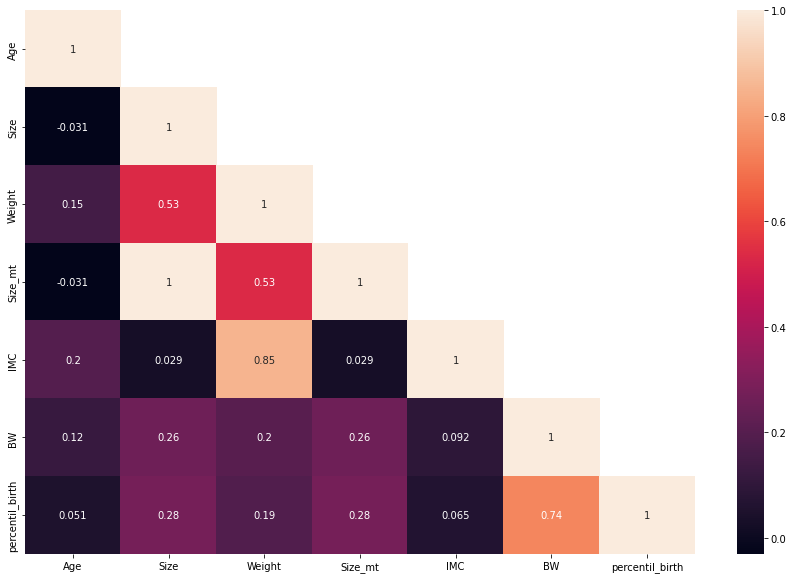

In [15]:
correlation=dades.loc[:,'Age':].corr()
mask = np.triu(np.ones_like(correlation, dtype=np.bool))
for i in range(mask.shape[0]):
  mask[i,i]=False

fig, ax=plt.subplots(figsize=(15,10))
sns.heatmap(correlation,mask=mask,annot=True)

fig.show()

Boxplot for Weight-UCI and Age-UCI

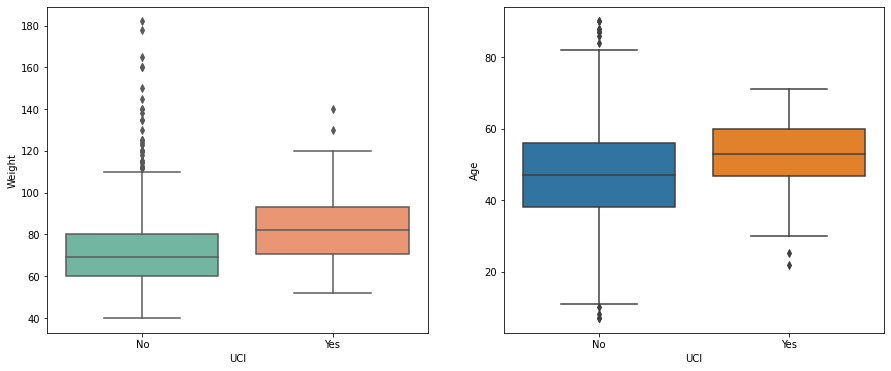

In [16]:
fig, ax=plt.subplots(1,2,figsize=(15,6))

sns.boxplot(x='UCI',y='Weight',data=dades,palette=sns.color_palette('Set2'), ax=ax[0])

sns.boxplot(x='UCI',y='Age',data=dades,palette=sns.color_palette(), ax=ax[1])

# Heatmap of p-values:

In [17]:
dades_categoriques=dades[['UCI']+['BW_2500']+list(dades.columns[list(dades.columns).index('IUGR_calc'):len(dades.columns)])+['Gender']].apply(lambda x : pd.factorize(x)[0])+1
factors_paired = [(i,j) for i in dades_categoriques.columns.values for j in dades_categoriques.columns.values] 

chi2, p_values =[], []

for f in factors_paired:
    if f[0] != f[1]:
        chitest = chi2_contingency(pd.crosstab(dades_categoriques[f[0]], dades_categoriques[f[1]]))   
        chi2.append(chitest[0])
        p_values.append(chitest[1])
    else:      # for same factor pair
        chi2.append(0)
        p_values.append(0)

chi2 = np.array(chi2).reshape((16,16)) # shape it as a matrix
p_values=np.array(p_values).reshape((16,16))
chi2 = pd.DataFrame(chi2, index=dades_categoriques.columns.values, columns=dades_categoriques.columns.values) # then a df for convenience
p_values=pd.DataFrame(p_values, index=dades_categoriques.columns.values, columns=dades_categoriques.columns.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


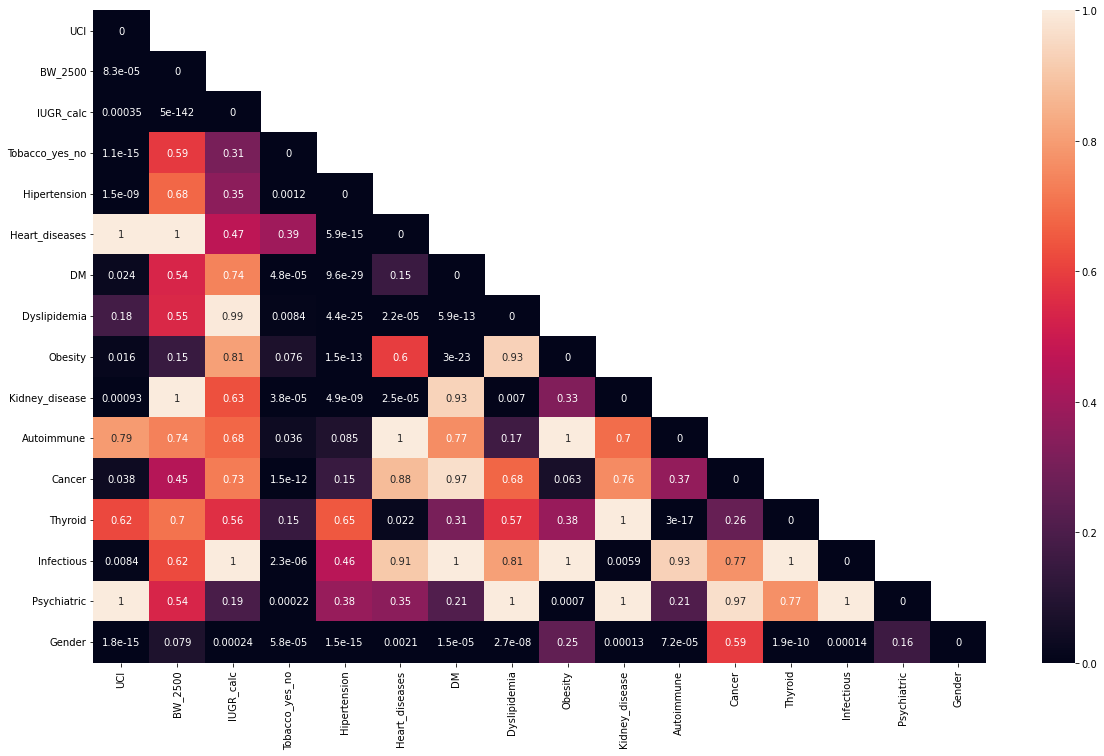

In [18]:
mask = np.triu(np.ones_like(p_values, dtype=np.bool))
for i in range(mask.shape[0]):
  mask[i,i]=False

fig, ax=plt.subplots(figsize=(20,12))
sns.heatmap(p_values, mask=mask,annot=True)

fig.show()

# Heat-map for chi-statistic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


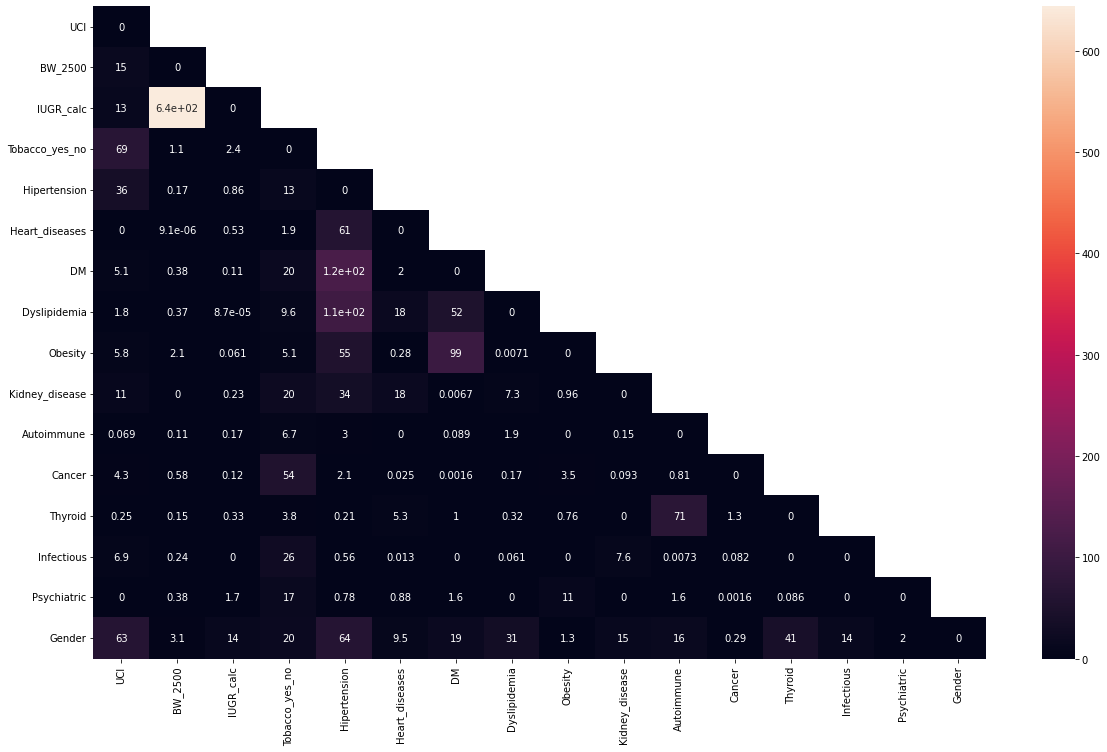

In [19]:
mask = np.triu(np.ones_like(chi2, dtype=np.bool))
for i in range(mask.shape[0]):
  mask[i,i]=False

fig,ax=plt.subplots(figsize=(20,12)) 
sns.heatmap(chi2, mask=mask,annot=True)
fig.show()

# Training of the Random Forest models using the library H2O

# Random forest with the data without resampling:

In [20]:
train = dades_train.copy()
test = dades_test.copy()

train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

predictors_train = [e for e in train_h2o.columns if e not in ['IUGR_missing','UCI','Size','BW']]

params1 = {'ntrees': [500,600,700],
          'max_depth': [3,4,5,6,7],
          'min_rows': [6,10,15,20],
          'mtries': [-1]}

grid = H2OGridSearch(model = H2ORandomForestEstimator(seed = 123),
                     grid_id = 'gbm_grid1',
                     hyper_params = params1,
                     search_criteria = {'strategy': "Cartesian"})

grid_models = grid.train(x=predictors_train,
                       y='UCI',
                       training_frame=train_h2o)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


Let's calculate the accuracies for the two categories of UCI using all the models we have trained and we will test different decision boundaries to choose the best one:

In [21]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore") #We ignore the warnings when we predict the whole datatset to be 'Yes' or 'No'
  
  candidates = pd.DataFrame()

  for model_reference, model in enumerate(grid_models):
    predictions = model.predict(test_h2o.drop('UCI',axis=1)).as_data_frame()
    accuracies = []

    for prob in np.arange(0, 1, 0.025).tolist():
      mask = (predictions['No'] >= prob)
      predictions['predictions_prob'] = ['No' if elem_mask else 'Yes' for elem_mask in mask]
      report = classification_report(test['UCI'], predictions['predictions_prob'], output_dict=True)
      accuracies.append({'model reference': model_reference ,'probability limit': prob, 'precision for No': report['No']['precision'], 'precision for Yes': report['Yes']['precision']})

    accuracies_df = pd.DataFrame(accuracies)
    best_accuracies = accuracies_df.loc[(accuracies_df['precision for No'] >= 0.9) & (accuracies_df['precision for Yes'] >= 0.18)]
    
    candidates = pd.concat([candidates, best_accuracies])

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

In [22]:
best_models_references = candidates.loc[candidates['precision for No'] == candidates['precision for No'].max()]['model reference']

best_RFmodels = [grid_models[i] for i in best_models_references]

In [23]:
print(best_RFmodels)

print(candidates.loc[candidates['precision for No'] == candidates['precision for No'].max()])

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  gbm_grid1_model_55


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,700.0,700.0,220858.0,5.0,7.0,6.97,9.0,30.0,20.414286




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.04038764314913326
RMSE: 0.20096677125617873
LogLoss: 0.15655315083554658
Mean Per-Class Error: 0.3832472748135399
AUC: 0.8100802521618314
AUCPR: 0.17008787375124926
Gini: 0.6201605043236629

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14221866357985727: 


,,No,Yes,Error,Rate
0,No,1688.0,55.0,0.0316,(55.0/1743.0)
1,Yes,61.0,22.0,0.7349,(61.0/83.0)
2,Total,1749.0,77.0,0.0635,(116.0/1826.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.142219,0.275000,56.0
1,max f2,0.069928,0.382550,178.0
2,max f0point5,0.147178,0.289256,53.0
3,max accuracy,0.244234,0.953998,0.0
4,max precision,0.194870,0.350000,19.0
5,max recall,0.006020,1.000000,374.0
6,max specificity,0.244234,0.999426,0.0
7,max absolute_mcc,0.147178,0.243986,53.0
8,max min_per_class_accuracy,0.059322,0.737808,203.0
9,max mean_per_class_accuracy,0.053816,0.747562,217.0



Gains/Lift Table: Avg response rate:  4.55 %, avg score:  4.50 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010405,0.196473,6.947368,6.947368,0.315789,0.212460,0.315789,0.212460,0.072289,0.072289,594.736842,594.736842,0.064831
1,2,0.020263,0.171739,3.666667,5.351351,0.166667,0.183993,0.243243,0.198611,0.036145,0.108434,266.666667,435.135135,0.092369
2,3,0.030120,0.158260,7.333333,6.000000,0.333333,0.166510,0.272727,0.188105,0.072289,0.180723,633.333333,500.000000,0.157774
3,4,0.040526,0.144482,6.947368,6.243243,0.315789,0.151020,0.283784,0.178583,0.072289,0.253012,594.736842,524.324324,0.222605
4,5,0.050383,0.132249,2.444444,5.500000,0.111111,0.137223,0.250000,0.170491,0.024096,0.277108,144.444444,450.000000,0.237522
5,6,0.100219,0.107148,2.175824,3.846995,0.098901,0.117453,0.174863,0.144117,0.108434,0.385542,117.582418,284.699454,0.298910
6,7,0.150055,0.088451,2.659341,3.452555,0.120879,0.095811,0.156934,0.128074,0.132530,0.518072,165.934066,245.255474,0.385542
7,8,0.200438,0.075967,1.913043,3.065574,0.086957,0.081721,0.139344,0.116422,0.096386,0.614458,91.304348,206.557377,0.433735
8,9,0.300110,0.057248,1.329670,2.489051,0.060440,0.065449,0.113139,0.099493,0.132530,0.746988,32.967033,148.905109,0.468158
9,10,0.400329,0.041210,0.841530,2.076607,0.038251,0.049168,0.094391,0.086895,0.084337,0.831325,-15.846995,107.660739,0.451520




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-07-23 15:30:45,4 min 58.670 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-07-23 15:30:45,4 min 58.677 sec,1.0,0.190055,0.326893,0.703622,0.100202,3.437500,0.126677
2,,2022-07-23 15:30:45,4 min 58.693 sec,2.0,0.206894,0.442122,0.711806,0.113271,4.782609,0.173236
3,,2022-07-23 15:30:45,4 min 58.707 sec,3.0,0.202249,0.353454,0.737557,0.114840,3.473684,0.157781
4,,2022-07-23 15:30:45,4 min 58.724 sec,4.0,0.208545,0.287983,0.747268,0.121754,3.473684,0.173885
5,,2022-07-23 15:30:45,4 min 58.736 sec,5.0,0.203714,0.219224,0.766506,0.129793,4.631579,0.135593
6,,2022-07-23 15:30:45,4 min 58.749 sec,6.0,0.203395,0.220148,0.749799,0.124467,4.631579,0.088304
7,,2022-07-23 15:30:45,4 min 58.772 sec,7.0,0.204577,0.236929,0.746478,0.158751,5.789474,0.082763
8,,2022-07-23 15:30:45,4 min 58.791 sec,8.0,0.204146,0.219066,0.741988,0.135778,5.789474,0.087937
9,,2022-07-23 15:30:45,4 min 58.807 sec,9.0,0.203531,0.233967,0.744283,0.147187,6.947368,0.089087



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,IMC,759.192810,1.000000,0.163263
1,Tobacco_yes_no,632.188660,0.832712,0.135951
2,Gender,626.451599,0.825155,0.134717
3,percentil_birth,608.044373,0.800909,0.130759
4,Weight,510.367859,0.672251,0.109754
5,Age,469.471680,0.618383,0.100959
6,Size_mt,427.561676,0.563179,0.091946
7,Hipertension,313.350983,0.412742,0.067386
8,IUGR_calc,128.875412,0.169753,0.027714
9,BW_2500,96.284592,0.126825,0.020706


Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  gbm_grid1_model_35


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,600.0,600.0,188873.0,5.0,7.0,6.966667,9.0,30.0,20.358334




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.04040790730150928
RMSE: 0.2010171816077155
LogLoss: 0.15669461126041603
Mean Per-Class Error: 0.382960413080895
AUC: 0.8093510012511319
AUCPR: 0.16955386098354092
Gini: 0.6187020025022638

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14326431210450813: 


,,No,Yes,Error,Rate
0,No,1689.0,54.0,0.031,(54.0/1743.0)
1,Yes,61.0,22.0,0.7349,(61.0/83.0)
2,Total,1750.0,76.0,0.063,(115.0/1826.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.143264,0.276730,51.0
1,max f2,0.070154,0.376851,173.0
2,max f0point5,0.146805,0.292479,47.0
3,max accuracy,0.252240,0.953998,0.0
4,max precision,0.204576,0.333333,9.0
5,max recall,0.006045,1.000000,375.0
6,max specificity,0.252240,0.999426,0.0
7,max absolute_mcc,0.146805,0.246305,47.0
8,max min_per_class_accuracy,0.059220,0.738382,199.0
9,max mean_per_class_accuracy,0.052537,0.746701,218.0



Gains/Lift Table: Avg response rate:  4.55 %, avg score:  4.49 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010405,0.193940,6.947368,6.947368,0.315789,0.212403,0.315789,0.212403,0.072289,0.072289,594.736842,594.736842,0.064831
1,2,0.020263,0.172637,4.888889,5.945946,0.222222,0.183257,0.270270,0.198224,0.048193,0.120482,388.888889,494.594595,0.104991
2,3,0.030120,0.155421,4.888889,5.600000,0.222222,0.166518,0.254545,0.187848,0.048193,0.168675,388.888889,460.000000,0.145152
3,4,0.040526,0.143859,8.105263,6.243243,0.368421,0.150049,0.283784,0.178143,0.084337,0.253012,710.526316,524.324324,0.222605
4,5,0.050383,0.130417,1.222222,5.260870,0.055556,0.136330,0.239130,0.169962,0.012048,0.265060,22.222222,426.086957,0.224900
5,6,0.100219,0.106862,2.417582,3.846995,0.109890,0.117243,0.174863,0.143746,0.120482,0.385542,141.758242,284.699454,0.298910
6,7,0.150055,0.088433,2.901099,3.532847,0.131868,0.096080,0.160584,0.127916,0.144578,0.530120,190.109890,253.284672,0.398164
7,8,0.200438,0.076086,1.434783,3.005464,0.065217,0.082041,0.136612,0.116384,0.072289,0.602410,43.478261,200.546448,0.421113
8,9,0.300110,0.056792,1.450549,2.489051,0.065934,0.065279,0.113139,0.099411,0.144578,0.746988,45.054945,148.905109,0.468158
9,10,0.400329,0.041175,0.721311,2.046512,0.032787,0.048774,0.093023,0.086735,0.072289,0.819277,-27.868852,104.651163,0.438898




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-07-23 15:28:50,3 min 3.349 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-07-23 15:28:50,3 min 3.358 sec,1.0,0.190055,0.326893,0.703622,0.100202,3.437500,0.126677
2,,2022-07-23 15:28:50,3 min 3.366 sec,2.0,0.206894,0.442122,0.711806,0.113271,4.782609,0.173236
3,,2022-07-23 15:28:50,3 min 3.374 sec,3.0,0.202249,0.353454,0.737557,0.114840,3.473684,0.157781
4,,2022-07-23 15:28:50,3 min 3.382 sec,4.0,0.208545,0.287983,0.747268,0.121754,3.473684,0.173885
5,,2022-07-23 15:28:50,3 min 3.391 sec,5.0,0.203714,0.219224,0.766506,0.129793,4.631579,0.135593
6,,2022-07-23 15:28:50,3 min 3.400 sec,6.0,0.203395,0.220148,0.749799,0.124467,4.631579,0.088304
7,,2022-07-23 15:28:50,3 min 3.411 sec,7.0,0.204577,0.236929,0.746478,0.158751,5.789474,0.082763
8,,2022-07-23 15:28:50,3 min 3.422 sec,8.0,0.204146,0.219066,0.741988,0.135778,5.789474,0.087937
9,,2022-07-23 15:28:50,3 min 3.434 sec,9.0,0.203531,0.233967,0.744283,0.147187,6.947368,0.089087



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,IMC,653.525024,1.000000,0.164073
1,Tobacco_yes_no,535.275024,0.819058,0.134385
2,Gender,532.890564,0.815410,0.133786
3,percentil_birth,523.210754,0.800598,0.131356
4,Weight,432.678558,0.662069,0.108627
5,Age,410.132263,0.627569,0.102967
6,Size_mt,362.251831,0.554304,0.090946
7,Hipertension,274.433746,0.419928,0.068899
8,IUGR_calc,107.880447,0.165075,0.027084
9,BW_2500,84.725136,0.129643,0.021271


Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  gbm_grid1_model_15


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,500.0,500.0,157483.0,5.0,7.0,6.962,9.0,30.0,20.376




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.04044177610629628
RMSE: 0.20110140751943106
LogLoss: 0.15693211673597915
Mean Per-Class Error: 0.38267355134825015
AUC: 0.8078786747679185
AUCPR: 0.16799215560339756
Gini: 0.615757349535837

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14369578145991607: 


,,No,Yes,Error,Rate
0,No,1690.0,53.0,0.0304,(53.0/1743.0)
1,Yes,61.0,22.0,0.7349,(61.0/83.0)
2,Total,1751.0,75.0,0.0624,(114.0/1826.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.143696,0.278481,53.0
1,max f2,0.071773,0.376197,171.0
2,max f0point5,0.143696,0.287206,53.0
3,max accuracy,0.253972,0.953998,0.0
4,max precision,0.194784,0.333333,14.0
5,max recall,0.006177,1.000000,372.0
6,max specificity,0.253972,0.999426,0.0
7,max absolute_mcc,0.092259,0.246573,129.0
8,max min_per_class_accuracy,0.059078,0.735513,201.0
9,max mean_per_class_accuracy,0.053894,0.749570,215.0



Gains/Lift Table: Avg response rate:  4.55 %, avg score:  4.50 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010405,0.193224,6.947368,6.947368,0.315789,0.212196,0.315789,0.212196,0.072289,0.072289,594.736842,594.736842,0.064831
1,2,0.020263,0.173804,4.888889,5.945946,0.222222,0.182549,0.270270,0.197773,0.048193,0.120482,388.888889,494.594595,0.104991
2,3,0.030120,0.155596,6.111111,6.000000,0.277778,0.165993,0.272727,0.187372,0.060241,0.180723,511.111111,500.000000,0.157774
3,4,0.040526,0.143814,8.105263,6.540541,0.368421,0.149177,0.297297,0.177565,0.084337,0.265060,710.526316,554.054054,0.235227
4,5,0.050383,0.131060,1.222222,5.500000,0.055556,0.136671,0.250000,0.169564,0.012048,0.277108,22.222222,450.000000,0.237522
5,6,0.100219,0.105398,2.417582,3.967213,0.109890,0.117454,0.180328,0.143651,0.120482,0.397590,141.758242,296.721311,0.311532
6,7,0.150055,0.088770,2.659341,3.532847,0.120879,0.096448,0.160584,0.127974,0.132530,0.530120,165.934066,253.284672,0.398164
7,8,0.200438,0.076081,1.434783,3.005464,0.065217,0.082233,0.136612,0.116476,0.072289,0.602410,43.478261,200.546448,0.421113
8,9,0.300110,0.056596,1.450549,2.489051,0.065934,0.065453,0.113139,0.099531,0.144578,0.746988,45.054945,148.905109,0.468158
9,10,0.400329,0.041721,0.721311,2.046512,0.032787,0.049027,0.093023,0.086888,0.072289,0.819277,-27.868852,104.651163,0.438898




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-07-23 15:27:04,1 min 17.003 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-07-23 15:27:04,1 min 17.009 sec,1.0,0.190055,0.326893,0.703622,0.100202,3.437500,0.126677
2,,2022-07-23 15:27:04,1 min 17.018 sec,2.0,0.206894,0.442122,0.711806,0.113271,4.782609,0.173236
3,,2022-07-23 15:27:04,1 min 17.028 sec,3.0,0.202249,0.353454,0.737557,0.114840,3.473684,0.157781
4,,2022-07-23 15:27:04,1 min 17.038 sec,4.0,0.208545,0.287983,0.747268,0.121754,3.473684,0.173885
5,,2022-07-23 15:27:04,1 min 17.047 sec,5.0,0.203714,0.219224,0.766506,0.129793,4.631579,0.135593
6,,2022-07-23 15:27:04,1 min 17.055 sec,6.0,0.203395,0.220148,0.749799,0.124467,4.631579,0.088304
7,,2022-07-23 15:27:04,1 min 17.065 sec,7.0,0.204577,0.236929,0.746478,0.158751,5.789474,0.082763
8,,2022-07-23 15:27:04,1 min 17.074 sec,8.0,0.204146,0.219066,0.741988,0.135778,5.789474,0.087937
9,,2022-07-23 15:27:04,1 min 17.086 sec,9.0,0.203531,0.233967,0.744283,0.147187,6.947368,0.089087



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,IMC,549.492676,1.000000,0.165148
1,Tobacco_yes_no,452.754822,0.823951,0.136074
2,percentil_birth,437.803680,0.796742,0.131580
3,Gender,428.377869,0.779588,0.128747
4,Weight,359.416016,0.654087,0.108021
5,Age,348.026733,0.633360,0.104598
6,Size_mt,305.878418,0.556656,0.091931
7,Hipertension,234.953323,0.427582,0.070614
8,IUGR_calc,80.238884,0.146024,0.024116
9,BW_2500,74.017273,0.134701,0.022246


[, , ]
    model reference  probability limit  precision for No  precision for Yes
37               17              0.925          0.988732           0.205882
37               20              0.925          0.988732           0.205882
37               24              0.925          0.988732           0.205882


Using the parsimony principle we keep the most simple model which in this case is the one with the reference 24. Let's search it on the grid:

In [24]:
grid_models

      max_depth  min_rows  mtries  ntrees           model_ids   logloss
0           7.0       6.0    -1.0   700.0  gbm_grid1_model_45  0.154420
1           6.0       6.0    -1.0   700.0  gbm_grid1_model_44  0.154468
2           7.0       6.0    -1.0   600.0  gbm_grid1_model_25  0.154487
3           6.0       6.0    -1.0   500.0   gbm_grid1_model_4  0.154507
4           7.0       6.0    -1.0   500.0   gbm_grid1_model_5  0.154523
5           6.0       6.0    -1.0   600.0  gbm_grid1_model_24  0.154551
6           5.0       6.0    -1.0   700.0  gbm_grid1_model_43  0.155254
7           5.0       6.0    -1.0   600.0  gbm_grid1_model_23  0.155321
8           5.0       6.0    -1.0   500.0   gbm_grid1_model_3  0.155368
9           7.0      10.0    -1.0   700.0  gbm_grid1_model_50  0.155580
10          7.0      10.0    -1.0   600.0  gbm_grid1_model_30  0.155777
11          7.0      10.0    -1.0   500.0  gbm_grid1_model_10  0.155805
12          6.0      10.0    -1.0   700.0  gbm_grid1_model_49  0

We find that it's the model with key: gbm_grid1_model_15 in our grid, so we search it and we retrain another model with the same caracteristics which are:
* ntrees=500
* max_depth=7
* min_rows=15
* probability decision margin=0.925

In [25]:
predictors_train = [e for e in train_h2o.columns if e not in ['IUGR_missing','UCI','Size','BW']]

model_best = H2ORandomForestEstimator(ntrees=500,
                                    max_depth=7,
                                    min_rows=15,
                                    seed=123,
                                    mtries=-1)
model_best=model_best.train(x=predictors_train,
                       y='UCI',
                       training_frame=train_h2o)

model_best_predictions = model_best.predict(test_h2o.drop('UCI',axis=1)).as_data_frame()

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


We do the predictions:

In [27]:
model_best_predictions['predict'] = model_best_predictions['No'] >= 0.925
model_best_predictions['predict'] = ['No' if elem else 'Yes' for elem in model_best_predictions['predict']]
model_best_predictions['real_values'] = list(test['UCI'])

And we check the results:

In [28]:
print(len(model_best_predictions.loc[(model_best_predictions['predict'] == 'No') & (model_best_predictions['real_values'] == 'Yes')]))

print(len(model_best_predictions.loc[(model_best_predictions['predict'] == 'Yes') & (model_best_predictions['real_values'] == 'No')]))

4
81


In [43]:
print(len(model_best_predictions.loc[(model_best_predictions['predict'] == 'Yes') & (model_best_predictions['real_values'] == 'Yes')]))

print(len(model_best_predictions.loc[(model_best_predictions['predict'] == 'Yes')]))

21
102


We can see that we have very few patients that we predict to be 'No' and are 'Yes'

# Random forest with the upsampled data:

In [27]:
dades_train_UCI_No=dades_train[dades_train['UCI']=='No']
dades_train_UCI_Yes=dades_train[dades_train['UCI']=='Yes']
dades_UCI_Yes_upsampled=resample(dades_train_UCI_Yes,replace=True,n_samples=len(dades_train_UCI_No),random_state=123)
dades_train_upsampled=pd.concat([dades_train_UCI_No,dades_UCI_Yes_upsampled])

As we can see the number of rows has changed, having now the same amount of pacients with UCI=='Yes' and UCI=='No'

In [28]:
print(len(dades_train_upsampled))
print(len(dades_train_upsampled.loc[dades_train_upsampled['UCI']=='Yes']))
print(len(dades_train_upsampled.loc[dades_train_upsampled['UCI']=='No']))

3486
1743
1743


Let's check if training the models with the new data has better results on the test frame:

In [29]:
dades_train_upsampled_h2o=h2o.H2OFrame(dades_train_upsampled)

predictors_train_upsampled = [e for e in dades_train_upsampled_h2o.columns if e not in ['IUGR_missing','UCI','Size','BW']]

params1 = {'ntrees': [500,600,700],
          'max_depth': [3,4,5,6,7],
          'min_rows': [6,10,15,20],
          'mtries': [-1]}

grid_upsampled = H2OGridSearch(model = H2ORandomForestEstimator(seed = 123),
                     grid_id = 'gbm_grid2',
                     hyper_params = params1,
                     search_criteria = {'strategy': "Cartesian"})

grid_models_upsampled = grid_upsampled.train(x=predictors_train_upsampled,
                       y='UCI',
                       training_frame=dades_train_upsampled_h2o)

candidates_upsampled = pd.DataFrame()

with warnings.catch_warnings():
  warnings.simplefilter("ignore") #We ignore the warnings when we predict the whole datatset to be 'Yes' pr 'No'

  for model_reference, model in enumerate(grid_models_upsampled):
    predictions = model.predict(test_h2o.drop('UCI',axis=1)).as_data_frame()
    accuracies = []

    for prob in np.arange(0, 1, 0.025).tolist():
      mask = (predictions['No'] >= prob)
      predictions['predictions_prob'] = ['No' if elem_mask else 'Yes' for elem_mask in mask]
      report = classification_report(test['UCI'], predictions['predictions_prob'], output_dict=True)
      accuracies.append({'model reference': model_reference ,'probability limit': prob, 'precision for No': report['No']['precision'], 'precision for Yes': report['Yes']['precision']})

    accuracies_df = pd.DataFrame(accuracies)
    best_accuracies = accuracies_df.loc[(accuracies_df['precision for No'] >= 0.9) & (accuracies_df['precision for Yes'] >= 0.18)]
    
    candidates_upsampled = pd.concat([candidates_upsampled, best_accuracies])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |████████████████████████

In [30]:
best_models_references_upsampled = candidates_upsampled.loc[candidates_upsampled['precision for No'] == candidates_upsampled['precision for No'].max()]['model reference']

best_RFmodels_upsampled = [grid_models_upsampled[i] for i in best_models_references_upsampled]

In [31]:
grid_models_upsampled

      max_depth  min_rows  mtries  ntrees           model_ids   logloss
0           7.0       6.0    -1.0   600.0  gbm_grid2_model_25  0.323067
1           7.0       6.0    -1.0   700.0  gbm_grid2_model_45  0.323165
2           7.0       6.0    -1.0   500.0   gbm_grid2_model_5  0.323490
3           7.0      10.0    -1.0   500.0  gbm_grid2_model_10  0.337059
4           7.0      10.0    -1.0   600.0  gbm_grid2_model_30  0.337179
5           7.0      10.0    -1.0   700.0  gbm_grid2_model_50  0.337532
6           7.0      15.0    -1.0   500.0  gbm_grid2_model_15  0.355277
7           7.0      15.0    -1.0   600.0  gbm_grid2_model_35  0.355470
8           7.0      15.0    -1.0   700.0  gbm_grid2_model_55  0.355673
9           6.0       6.0    -1.0   700.0  gbm_grid2_model_44  0.361367
10          6.0       6.0    -1.0   600.0  gbm_grid2_model_24  0.361399
11          6.0       6.0    -1.0   500.0   gbm_grid2_model_4  0.361529
12          6.0      10.0    -1.0   500.0   gbm_grid2_model_9  0

In [32]:
print(candidates_upsampled.loc[candidates_upsampled['precision for No'] == candidates_upsampled['precision for No'].max()])

    model reference  probability limit  precision for No  precision for Yes
20                8                0.5          0.983146           0.188119


This time we only get one model with the best performance that goes by the reference of gbm_grid2_model_55 and has the folowing hyperparameters:
* ntrees=700
* max_depth=7
* min_rows=15
* probability decision margin=0.5

In [33]:
predictors_train_upsampled = [e for e in dades_train_upsampled_h2o.columns if e not in ['IUGR_missing','UCI','Size','BW']]

model_best_upsampled = H2ORandomForestEstimator(ntrees=700,
                                    max_depth=7,
                                    min_rows=15,
                                    seed=123,
                                    mtries=-1)
model_best_upsampled=model_best.train(x=predictors_train_upsampled,
                       y='UCI',
                       training_frame=dades_train_upsampled_h2o)

model_best_predictions_upsampled = model_best_upsampled.predict(test_h2o.drop('UCI',axis=1)).as_data_frame()

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


We check the results:

In [34]:
model_best_predictions_upsampled['predict'] = model_best_predictions_upsampled['No'] >= 0.5
model_best_predictions_upsampled['predict'] = ['No' if elem else 'Yes' for elem in model_best_predictions_upsampled['predict']]
model_best_predictions_upsampled['real_values'] = list(test['UCI'])

In [35]:
print(classification_report(model_best_predictions_upsampled['real_values'], model_best_predictions_upsampled['predict']))

              precision    recall  f1-score   support

          No       0.98      0.81      0.89       432
         Yes       0.19      0.76      0.30        25

    accuracy                           0.81       457
   macro avg       0.58      0.78      0.59       457
weighted avg       0.94      0.81      0.85       457



The performance of the model does not increase so we will use as our winning model the one trained with the original data to not overcomplicate things.

# Conclusions of the Random Forest model:

So from the 120 Random forest models we have trained that contain 72k decision trees we conclude that the model with the best performance has the following characteristics:
* ntrees=500
* max_depth=7
* min_rows=15
* probability decision margin=0.925

and is trained with the origninal trainging dataset.
This model has the following accuracies:

In [36]:
print(classification_report(model_best_predictions['real_values'], model_best_predictions['predict']))

              precision    recall  f1-score   support

          No       0.99      0.81      0.89       432
         Yes       0.21      0.84      0.33        25

    accuracy                           0.81       457
   macro avg       0.60      0.83      0.61       457
weighted avg       0.95      0.81      0.86       457



So let's consider that we have a list of 457 patients (lenght of the test sample) and the hospital asks us what are the patients that have a higher probability of ending up a the UCI if they are infected with the disease Covid-19. Of course the hospital has a limited capacity so our main goal will we to discard as many patients as posible commiting very few false negatives (patients which we predict that will be fine but if they are infected will have severe symtoms of the disease). This are the outputs of our model:

In [37]:
print('Patients predicted to NOT have severe symtoms:' + str(len(model_best_predictions.loc[model_best_predictions['predict'] == 'No'])))
print('Patients predicted to have severe symtoms:' + str(len(model_best_predictions.loc[model_best_predictions['predict'] == 'Yes'])))

Patients predicted to NOT have severe symtoms:355
Patients predicted to have severe symtoms:102


So from the beggining we will discard 77% of all the patients. But the most important result is the following: From the 355 patients that we predicted to not have severe symtoms only 4 of them will acctualy suffer in reality complications which is only a 1% margin of error.